In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests


from lmmnn.utils import generate_data
from lmmnn.layers import NLL
from lmmnn.nn import reg_nn_lmm
from lmmnn.calc_b_hat import *

from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,GRU,Dropout, Flatten, Input, ReLU
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import mean_squared_error as mse

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
import os



In [2]:
aPath = '--xla_gpu_cuda_data_dir=C:/Users/AndrejTschalzev/anaconda3/Library/bin'
print(aPath)
os.environ['XLA_FLAGS'] = aPath

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline
plt.style.use('ggplot')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



--xla_gpu_cuda_data_dir=C:/Users/AndrejTschalzev/anaconda3/Library/bin
SUCCESS: Found GPU: /device:GPU:0


## Generate Regression data

In [84]:
params = {
    "n_fixed_effects": 10,
    "fixed_intercept": 1,
    "X_non_linear": True,
    "Z_non_linear": False,
    "Z_embed_dim_pct": 10,
    "n_per_cat": 3,
    "test_size": 0.2,
}

# qs=[100,1000,10000] # use this if you want 3 z variables
# sig2bs=[0.1,1,10]

# datasets = {}
# for q in [100,1000,10000]:
#     for sig2b in [0.1,1,10]:
#         datasets[str(q)+"_"+str(sig2b)] = generate_data(mode='intercept', qs=[q], sig2e=1, sig2bs=[sig2b], sig2bs_spatial=[], q_spatial=[], N=100000, rhos=None, p_censor=None, params=params)#"./conf_files/conf_glmm.conf_glmm.yaml")


q = 10000
sig2b = 1.0
mode = "glmm"

X_train, X_test, y_train, y_test, x_cols, dist_matrix, time2measure_dict = generate_data(mode=mode, qs=[q], sig2e=1, sig2bs=[sig2b], sig2bs_spatial=[], q_spatial=[], N=100000, rhos=None, p_censor=None, params=params)#"./conf_files/conf_glmm.conf_glmm.yaml")

In [85]:
X_train.shape, len(x_cols)

((80000, 11), 10)

In [86]:
np.unique(X_train['z0'])

array([   0,    1,    2, ..., 9997, 9998, 9999])

## Random Forest

In [87]:
# Random Forest 

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.6445

In [88]:
# Random Forest using 1 z variable

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train[x_cols], y_train)
y_pred_rf = clf.predict(X_test[x_cols])
accuracy_score(y_test,y_pred_rf)

0.65135

In [89]:
model_nn = Sequential()
model_nn.add(Dense(100, activation='relu'))
model_nn.add(Dropout(.25))
model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dropout(.25))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

model_nn.fit(X_train[x_cols], y_train, epochs=500, batch_size=30, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                validation_data=(X_test[x_cols], y_test))
# Final evaluation of the model
y_pred_nn = model_nn.predict(X_test[x_cols]).ravel()
print("Accuracy: ", round(accuracy_score(y_test,np.round(y_pred_nn)),4))
print("AUC: ", round(roc_auc_score(y_test,np.round(y_pred_nn)),4))

Epoch 1/500
2667/2667 [==============================] - 14s 4ms/step - loss: 0.6325 - accuracy: 0.6355 - val_loss: 0.6019 - val_accuracy: 0.6633
Epoch 2/500
2667/2667 [==============================] - 12s 5ms/step - loss: 0.5989 - accuracy: 0.6611 - val_loss: 0.5738 - val_accuracy: 0.6834
Epoch 3/500
2667/2667 [==============================] - 21s 8ms/step - loss: 0.5835 - accuracy: 0.6766 - val_loss: 0.5672 - val_accuracy: 0.6909
Epoch 4/500
2667/2667 [==============================] - 31s 12ms/step - loss: 0.5796 - accuracy: 0.6811 - val_loss: 0.5662 - val_accuracy: 0.6934
Epoch 5/500
2667/2667 [==============================] - 32s 12ms/step - loss: 0.5764 - accuracy: 0.6851 - val_loss: 0.5652 - val_accuracy: 0.6917
Epoch 6/500
2667/2667 [==============================] - 26s 10ms/step - loss: 0.5761 - accuracy: 0.6848 - val_loss: 0.5675 - val_accuracy: 0.6920
Epoch 7/500
2667/2667 [==============================] - 10s 4ms/step - loss: 0.5749 - accuracy: 0.6884 - val_loss: 0.564

In [91]:
model_nn2 = Sequential()
model_nn2.add(Dense(100, activation='relu'))
model_nn2.add(Dropout(.25))
model_nn2.add(Dense(50, activation='relu'))
model_nn2.add(Dropout(.25))
model_nn2.add(Dense(25, activation='relu'))
model_nn2.add(Dropout(.25))
model_nn2.add(Dense(12, activation='relu'))
model_nn2.add(Dropout(.25))
model_nn2.add(Dense(1, activation='sigmoid'))
model_nn2.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

model_nn2.fit(X_train[x_cols], y_train, epochs=500, batch_size=30, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                validation_data=(X_test[x_cols], y_test))
# Final evaluation of the model
y_pred_nn = model_nn2.predict(X_test[x_cols]).ravel()
print("Accuracy: ", round(accuracy_score(y_test,np.round(y_pred_nn)),4))
print("AUC: ", round(roc_auc_score(y_test,np.round(y_pred_nn)),4))

Epoch 1/500
2667/2667 [==============================] - 27s 10ms/step - loss: 0.6400 - accuracy: 0.6229 - val_loss: 0.6033 - val_accuracy: 0.6524
Epoch 2/500
2667/2667 [==============================] - 28s 10ms/step - loss: 0.6074 - accuracy: 0.6488 - val_loss: 0.5881 - val_accuracy: 0.6708
Epoch 3/500
2667/2667 [==============================] - 28s 11ms/step - loss: 0.5955 - accuracy: 0.6636 - val_loss: 0.5752 - val_accuracy: 0.6841
Epoch 4/500
2667/2667 [==============================] - 29s 11ms/step - loss: 0.5887 - accuracy: 0.6745 - val_loss: 0.5728 - val_accuracy: 0.6888
Epoch 5/500
2667/2667 [==============================] - 28s 11ms/step - loss: 0.5846 - accuracy: 0.6806 - val_loss: 0.5664 - val_accuracy: 0.6912
Epoch 6/500
2667/2667 [==============================] - 28s 11ms/step - loss: 0.5810 - accuracy: 0.6835 - val_loss: 0.5674 - val_accuracy: 0.6912
Epoch 7/500
2667/2667 [==============================] - 16s 6ms/step - loss: 0.5800 - accuracy: 0.6845 - val_loss: 0.

## LMMNN

In [92]:
# batch = 100
# epochs = 10
# patience = 10
qs=[q]#,1000,10000]
q_spatial=[]
# n_neurons = [10, 5, 2]
# dropout = None
# activation = 'relu'
# mode = 'glmm'
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
# dist_matrix = None
# time2measure_dict = None
spatial_embed_neurons = None
verbose = True
Z_non_linear = False
# log_params = False
# idx = None
# Z_embed_dim_pct = 10
ls = None
sample_n_train=10000

In [93]:
# LMMNN using 3 z variables

mode = 'intercepts'
NUM_ITERATIONS = 1000
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DECAY_RATE = 0.0001

X_input = Input(shape=(len(x_cols),))
y_true_input = Input(shape=(1,))
Z_input = Input(shape=(1,), dtype=tf.int64)
hidden1 = Dense(units=100, activation='relu', input_dim=len(x_cols))(X_input)
dropout1 = Dropout(.25)(hidden1)
hidden2 = Dense(units=50, activation='relu', input_dim=len(x_cols))(dropout1)
dropout2 = Dropout(.25)(hidden2)
y_pred_output = Dense(units=1, activation='linear')(dropout2)
nll = NLL(mode, 1.0, [1.0])(y_true_input, y_pred_output, [Z_input])
model_lmmnn = Model(inputs=[X_input, y_true_input, Z_input], outputs=nll)

adam = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=DECAY_RATE, amsgrad=False)
model_lmmnn.compile(optimizer = adam)
# X_train.reset_index(inplace=True)
# X_train.sort_values(by=['z0'], inplace=True)
# y_train = y_train[X_train.index]

history = model_lmmnn.fit([X_train[x_cols], y_train, X_train['z0']], None, batch_size=BATCH_SIZE, epochs=200, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    validation_data=[[X_test[x_cols], y_test, X_test['z0']]], shuffle=True)

Epoch 1/200
2667/2667 [==============================] - 22s 8ms/step - loss: 23.2510 - val_loss: 18.7191
Epoch 2/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.8885 - val_loss: 18.3087
Epoch 3/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.5722 - val_loss: 18.0316
Epoch 4/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.4346 - val_loss: 18.0764
Epoch 5/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.3676 - val_loss: 18.0071
Epoch 6/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.3177 - val_loss: 17.9484
Epoch 7/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.2724 - val_loss: 17.9663
Epoch 8/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.2336 - val_loss: 17.9708
Epoch 9/200
2667/2667 [==============================] - 22s 8ms/step - loss: 18.2323 - val_loss: 17.9848
Epoch 10/200
2667/2667 [======================

In [94]:
sig2e_est, sig2b_ests, rho_ests, weibull_ests = model_lmmnn.layers[-1].get_vars()
sig2b_spatial_ests = []
z_cols = sorted(X_train.columns[X_train.columns.str.startswith('z')].tolist())
X_train_z_cols = [X_train[z_col] for z_col in z_cols]
X_test_z_cols = [X_test[z_col] for z_col in z_cols]
y_pred_tr = model_lmmnn.predict([X_train[x_cols], y_train] + X_train_z_cols).reshape(X_train.shape[0])

b_hat = calc_b_hat(X_train, y_train, y_pred_tr, qs, q_spatial, sig2e_est, sig2b_ests, sig2b_spatial_ests,
    Z_non_linear, model, ls, mode, rho_ests, est_cors, dist_matrix, weibull_ests, sample_n_train)
dummy_y_test = np.random.normal(size=y_test.shape)
dummy_y_train = np.random.normal(size=y_train.shape)

y_pred = model_lmmnn.predict([X_test[x_cols], dummy_y_test] + X_test_z_cols).reshape(
            X_test.shape[0]) + b_hat[X_test['z0']]
# y_pred = np.exp(y_pred)/(1 + np.exp(y_pred))

y_pred_fe = model_lmmnn.predict([X_test[x_cols], dummy_y_test] + X_test_z_cols).ravel()
# y_pred_fe = np.exp(y_pred_fe)/(1 + np.exp(y_pred_fe))

y_train_pred = model_lmmnn.predict([X_train[x_cols], dummy_y_train] + X_train_z_cols).reshape(
            X_train.shape[0]) + b_hat[X_train['z0']]
# y_train_pred = np.exp(y_train_pred)/(1 + np.exp(y_train_pred))

y_train_pred_fe = model_lmmnn.predict([X_train[x_cols], dummy_y_train] + X_train_z_cols).ravel()
# y_train_pred_fe = np.exp(y_train_pred_fe)/(1 + np.exp(y_train_pred_fe))



In [95]:
y_pred = np.round(y_pred)
y_pred_fe = np.round(y_pred_fe)
y_train_pred = np.round(y_train_pred)
y_train_pred_fe = np.round(y_train_pred_fe)

In [96]:
print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Train Accuracy (only FE): ", accuracy_score(y_train, y_train_pred_fe))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Test Accuracy (only FE): ", accuracy_score(y_test, y_pred_fe))

print("Train AUC: ", roc_auc_score(y_train, y_train_pred))
print("Train AUC (only FE): ", roc_auc_score(y_train, y_train_pred_fe))
print("Test AUC: ", roc_auc_score(y_test, y_pred))
print("Test AUC (only FE): ", roc_auc_score(y_test, y_pred_fe))

print("True/Learned sig2bs: {}/{}".format(sig2b,sig2b_ests))

z_available = np.unique(np.append(X_train["z0"].values,X_test["z0"].values))
z0_mean_ratings = pd.DataFrame([np.append(X_train["z0"].values,X_test["z0"].values),np.append(y_train,y_test)]).transpose().groupby(0).mean().values.ravel()
print("Correlation mean z0/raneffs: ", np.corrcoef([z0_mean_ratings, b_hat[z_available]])[0,1])


Train Accuracy:  0.7922125
Train Accuracy (only FE):  0.7009
Test Accuracy:  0.72615
Test Accuracy (only FE):  0.6922
Train AUC:  0.7826324599318661
Train AUC (only FE):  0.6887801368967922
Test AUC:  0.7153937763627627
Test AUC (only FE):  0.679881530943856
True/Learned sig2bs: 1.0/[0.03630264]
Correlation mean z0/raneffs:  0.8508590114402425


## MENN

In [97]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(X_train, key=k, dtype=np.float32)
    for k in X_train.columns}
fe_features = x_cols
labels_train = y_train

features_test = {k: get_value(X_test, key=k, dtype=np.float32)
                 for k in X_test.columns}
labels_test = y_test


num_z0 = q


In [98]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)


###### Define Model #############
class LinearMixedEffectModel(tf.Module):
    def __init__(self):
    # Set up fixed effects and other parameters.
    # These are free parameters to be optimized in E-steps
    # self._intercept = tf.Variable(0., name="intercept")            # alpha in eq
    # self._fixed_effects = tf.Variable([0.]*len(fe_features), name="fixed effects")  #  beta in eq
    # self.l1 = Dense(10, input_dim=3, activation="relu")
    # self.l2 = Dense(3, input_dim=3, activation="relu")
    # self.out_ = Dense(1, input_dim=3, activation="linear")
    # self.out_ = tfp.layers.DenseVariational(1, activation="relu")

        self.l1 = tf.Variable(initializer([len(fe_features),100]), name="l1", dtype=tf.float32)
        self.l1_bias = tf.Variable(initializer([100]), name="l1", dtype=tf.float32)
        self.l2 = tf.Variable(initializer([100,50]), name="l2", dtype=tf.float32)
        self.l2_bias = tf.Variable(initializer([50]), name="l2", dtype=tf.float32)
        self.out = tf.Variable(initializer([50]), name="out", dtype=tf.float32)
        self.out_bias = tf.Variable(initializer([1]), name="out", dtype=tf.float32)


        self._stddev_z0 = tfp.util.TransformedVariable(
            1., bijector=tfb.Exp(), name="stddev_z0")            # sigma in eq

    def NN_forward(self, features):
        feature_tensor = tf.transpose(tf.convert_to_tensor([features[feat] for feat in fe_features], dtype=tf.float32))
#         return tf.linalg.matvec(tf.nn.dropout(0.25)(ReLU()(tf.linalg.matmul(tf.nn.dropout(0.25)(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias)), self.l2) + self.l2_bias)), self.out) + self.out_bias
        return tf.linalg.matvec(ReLU()(tf.linalg.matmul(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias), self.l2) + self.l2_bias), self.out) + self.out_bias

    def __call__(self, features):
        feature_tensor = tf.transpose(tf.convert_to_tensor([features[feat] for feat in fe_features], dtype=tf.float32))

        model = tfd.JointDistributionSequentialAutoBatched([
          # Set up random effects.
          tfd.MultivariateNormalDiag(
              loc=tf.zeros(num_z0),
              scale_identity_multiplier=self._stddev_z0),
          # This is the likelihood for the observed.
          lambda effect_z0: tfd.Independent(
              tfd.Bernoulli(
                  logits=(tf.linalg.matvec(ReLU()(tf.linalg.matmul(ReLU()(tf.linalg.matmul(feature_tensor, self.l1) + self.l1_bias), self.l2) + self.l2_bias), self.out) + self.out_bias +
                      tf.gather(effect_z0, features["z0"].astype(int), axis=-1) 
                      )),
                  reinterpreted_batch_ndims=1)
        ])

        # To enable tracking of the trainable variables via the created distribution,
        # we attach a reference to `self`. Since all TFP objects sub-class
        # `tf.Module`, this means that the following is possible:
        # LinearMixedEffectModel()(features_train).trainable_variables
        # ==> tuple of all tf.Variables created by LinearMixedEffectModel.
        model._to_track = self
        return model

In [99]:
lmm_jointdist = LinearMixedEffectModel()
# Conditioned on feature/predictors from the training data
lmm_train = lmm_jointdist(features_train)
lmm_test = lmm_jointdist(features_test)


# Parameter Estimation
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
target_log_prob_test_fn = lambda *x: lmm_test.log_prob(x + (labels_test,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

# For debugging
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-77909.11>

In [100]:
# Set up E-step (MCMC).
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.005,
    num_leapfrog_steps=5)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
  next_state, next_kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=kernel_results)
  return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.0001)#, decay=0.0001)

# Set up M-step (gradient descent).
@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
  with tf.GradientTape() as tape:
    loss = -target_log_prob_fn(*current_state)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss


In [101]:
# Warm-up
num_warmup_iters = 1000
num_iters = 20000
num_accepted = 0
effect_z0_samples = []#np.zeros([num_iters, num_hosts])
loss_history = np.zeros([num_iters])

# Run warm-up stage.
for t in range(num_warmup_iters):
  current_state, kernel_results = one_e_step(current_state, kernel_results)
  num_accepted += kernel_results.is_accepted.numpy()
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

test_log_prob = []
# Run training.
for t in range(num_iters):
  # run 5 MCMC iterations before every joint EM update
  for _ in range(5):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
  if t==0:
      curr_test_prob = -target_log_prob_test_fn(*current_state).numpy()
      test_log_prob.append(curr_test_prob)

  loss = one_m_step(current_state)
  effect_z0_samples.append(current_state[0].numpy())
  num_accepted += kernel_results.is_accepted.numpy()

  # if np.all(loss_history[-10:] > loss.numpy()):
  #   print("Early stopping at iteration {}".format(t))
  #   print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
  #       t, num_accepted / (t + 1), loss_history[t]))
  #
  #   break

  loss_history[t] = loss.numpy()

  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_history[t]))



  if t % 500 == 0 or t == num_iters - 1:


      [
          effect_z0_mean,
      ] = [
          np.mean(x, axis=0).astype(np.float32) for x in [
              effect_z0_samples
          ]
      ]

      # Get the posterior predictive train distribution
      (*posterior_conditionals_train, ratings_posterior_train), _ = lmm_train.sample_distributions(
          value=(
              effect_z0_mean,
          ))

      ratings_prediction_train = np.round(ratings_posterior_train.mean())

      # Get the posterior predictive test distribution
      (*posterior_conditionals_test, ratings_posterior_test), _ = lmm_test.sample_distributions(
          value=(
              effect_z0_mean,
          ))

      ratings_prediction_test = np.round(ratings_posterior_test.mean())

      print("Iteration: {:>4} Performance".format(t))
      print("Train Accuracy: ", accuracy_score(labels_train, ratings_prediction_train))
      print("Test Accuracy: ", accuracy_score(labels_test, ratings_prediction_test))

      curr_test_prob = -target_log_prob_test_fn(*current_state).numpy()
      print("Test NLL: ", curr_test_prob)
      test_log_prob.append(curr_test_prob)

      if test_log_prob[-2]<curr_test_prob:
        print("Early stopping at iteration {} with test NLL={}".format(t, curr_test_prob))

        break



Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.998
Warm-Up Iteration: 999 Acceptance Rate: 0.997
Iteration:    0 Acceptance Rate: 1.000 Loss: 65146.277
Iteration:    0 Performance
Train Accuracy:  0.617525
Test Accuracy:  0.5651
Test NLL:  26803.29
Iteration:  500 Acceptance Rate: 1.000 Loss: 58357.387
Iteration:  500 Performance
Train Accuracy:  0.7099375
Test Accuracy:  0.6565
Test NLL:  25930.707
Iteration: 1000 Acceptance Rate: 0.998 Loss: 56397.035
Iteration: 1000 Performance
Train Accuracy:  0.7337375
Test Accuracy:  0.6787
Test NLL:  25658.32
Iteration: 1500 Acceptance Rate: 0.999 Loss: 54027.137
Iteration: 1500 Performance
Train Accuracy:  0.7596125
Test Accuracy:  0.7022
Test NLL:  24817.707
Iteration: 2000 Acceptance Rate: 0.999 Loss: 52797.910
Iteration: 2000 Performance
Train Accuracy:  0.773225
Test Accuracy:  0.71845
Test NLL:  24710.23
Iteration: 2500 Acceptance Rate: 0.999 Loss: 52461.746
Iteration: 2500 Performance
Train Accurac

In [102]:
effect_z0_samples = np.array(effect_z0_samples)


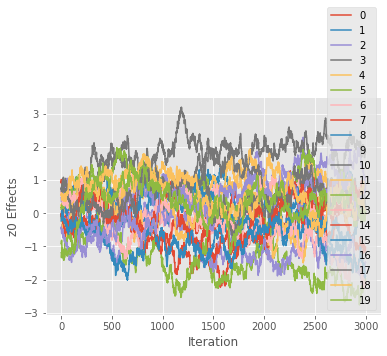

In [103]:
plt.style.use('ggplot')
# Effect transitions for first k effects
k = 20
for i in range(k):
  plt.plot(effect_z0_samples[:, 10+i])

plt.legend([i for i in range(k)], loc='lower right')
plt.ylabel('z0 Effects')
plt.xlabel('Iteration')
plt.show()

In [104]:
# Get probabilities
lmm_test = lmm_jointdist(features_test)

[
    effect_z0_mean,
] = [
     np.mean(x, axis=0).astype(np.float32) for x in [
       effect_z0_samples[500:]
       ]
]

# Get the posterior predictive train distribution
(*posterior_conditionals_train, ratings_posterior_train), _ = lmm_train.sample_distributions(
    value=(
        effect_z0_mean,
))

(*posterior_conditionals_fe_train, ratings_posterior_fe_train), _ = lmm_train.sample_distributions(
    value=(
        np.array([0]*len(effect_z0_mean)),
))


ratings_prediction_train = np.round(ratings_posterior_train.mean())
ratings_prediction_fe_train = np.round(ratings_posterior_fe_train.mean())

# Alternative für Fixed Effect Predictions
# y_FE = lmm_jointdist.NN_forward(features_train)

# Get the posterior predictive test distribution
(*posterior_conditionals_test, ratings_posterior_test), _ = lmm_test.sample_distributions(
    value=(
        effect_z0_mean,
))

(*posterior_conditionals_fe_test, ratings_posterior_fe_test), _ = lmm_test.sample_distributions(
    value=(
        np.array([0]*len(effect_z0_mean)),
        ))


ratings_prediction_test = np.round(ratings_posterior_test.mean())
ratings_prediction_fe_test = np.round(ratings_posterior_fe_test.mean())

print("Train Accuracy: ", accuracy_score(labels_train, ratings_prediction_train))
print("Train Accuracy (only FE): ", accuracy_score(labels_train, ratings_prediction_fe_train))
print("Test Accuracy: ", accuracy_score(labels_test, ratings_prediction_test))
print("Test Accuracy (only FE): ", accuracy_score(labels_test, ratings_prediction_fe_test))

print("Train AUC: ", roc_auc_score(labels_train, ratings_prediction_train))
print("Train AUC (only FE): ", roc_auc_score(labels_train, ratings_prediction_fe_train))
print("Test AUC: ", roc_auc_score(labels_test, ratings_prediction_test))
print("Test AUC (only FE): ", roc_auc_score(labels_test, ratings_prediction_fe_test))



z_available = np.unique(np.append(X_train["z0"].values,X_test["z0"].values))
z0_mean_ratings = pd.DataFrame([np.append(X_train["z0"].values,X_test["z0"].values),np.append(y_train,y_test)]).transpose().groupby(0).mean().values.ravel()
print("Correlation mean z0/raneffs: ", np.corrcoef([z0_mean_ratings, effect_z0_mean[z_available]])[0,1])


Train Accuracy:  0.781
Train Accuracy (only FE):  0.7001875
Test Accuracy:  0.7202
Test Accuracy (only FE):  0.69255
Train AUC:  0.7726350566604862
Train AUC (only FE):  0.6895140900468612
Test AUC:  0.7109665310507386
Test AUC (only FE):  0.6813958885897368
Correlation mean z0/raneffs:  0.7719216202115011


In [105]:
lmm_jointdist._stddev_z0.numpy()

array(0.9443812, dtype=float32)

In [106]:
sig2b_ests


array([0.03630264], dtype=float32)

In [87]:
x_cols = [col for col in X_train.columns if col not in ['z0','z1','z2']]
batch = 100
epochs = 10
patience = 10
qs=[100]#,1000,10000]
q_spatial=[]
n_neurons = [10, 5, 2]
dropout = None
activation = 'relu'
mode = 'glmm'
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
dist_matrix = None
time2measure_dict = None
spatial_embed_neurons = None
verbose = True
Z_non_linear = False
log_params = False
idx = None
Z_embed_dim_pct = 10


In [88]:
# simple
n_neurons = [5]
y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

Epoch 1/10
720/720 [==============================] - 4s 6ms/step - loss: 67.0956 - val_loss: 65.0391
Epoch 2/10
720/720 [==============================] - 3s 4ms/step - loss: 64.4057 - val_loss: 63.5360
Epoch 3/10
720/720 [==============================] - 4s 5ms/step - loss: 63.0351 - val_loss: 62.5357
Epoch 4/10
720/720 [==============================] - 4s 5ms/step - loss: 62.3010 - val_loss: 62.1152
Epoch 5/10
720/720 [==============================] - 4s 5ms/step - loss: 61.9573 - val_loss: 61.9300
Epoch 6/10
720/720 [==============================] - 4s 6ms/step - loss: 61.7883 - val_loss: 61.8486
Epoch 7/10
720/720 [==============================] - 4s 6ms/step - loss: 61.7039 - val_loss: 61.8190
Epoch 8/10
720/720 [==============================] - 5s 7ms/step - loss: 61.6554 - val_loss: 61.7972
Epoch 9/10
720/720 [==============================] - 4s 6ms/step - loss: 61.6223 - val_loss: 61.7755
Epoch 10/10
720/720 [==============================] - 4s 6ms/step - loss: 61.5933

In [90]:
# round predictions to closest integer
y_pred_class = []
for n in y_pred:
    y_pred_class.append(round(n))

accuracy_score(y_test, y_pred_class)

0.65925

In [43]:
# more complex
y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

Epoch 1/10
720/720 [==============================] - 4s 6ms/step - loss: 67.9445 - val_loss: 66.3830
Epoch 2/10
720/720 [==============================] - 4s 5ms/step - loss: 63.2507 - val_loss: 62.3688
Epoch 3/10
720/720 [==============================] - 4s 5ms/step - loss: 61.0069 - val_loss: 60.9193
Epoch 4/10
720/720 [==============================] - 4s 5ms/step - loss: 60.0911 - val_loss: 60.2229
Epoch 5/10
720/720 [==============================] - 4s 5ms/step - loss: 59.4728 - val_loss: 59.5839
Epoch 6/10
720/720 [==============================] - 4s 5ms/step - loss: 58.8078 - val_loss: 58.7403
Epoch 7/10
720/720 [==============================] - 4s 5ms/step - loss: 58.1545 - val_loss: 58.2428
Epoch 8/10
720/720 [==============================] - 4s 5ms/step - loss: 57.8414 - val_loss: 58.0293
Epoch 9/10
720/720 [==============================] - 4s 5ms/step - loss: 57.6636 - val_loss: 57.8732
Epoch 10/10
720/720 [==============================] - 4s 6ms/step - loss: 57.5537

In [44]:
y_pred

array([0.30334791, 0.32082577, 0.2263784 , ..., 0.13376543, 0.52185211,
       0.153196  ])

In [45]:
y_test

91505    1
42340    0
19847    0
22940    1
39723    0
        ..
15236    1
22404    0
13079    1
31917    0
6239     0
Name: y, Length: 20000, dtype: int32

In [46]:
len(y_pred) == len(y_test)

True

In [52]:
# round predictions to closest integer
y_pred_class = []
for n in y_pred:
    y_pred_class.append(round(n))

y_pred_class

[0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [54]:
accuracy_score(y_test, y_pred_class)

0.70115